In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import  os
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import  accuracy_score
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.cluster.vq import kmeans, vq

DATA_PATH= os.path.join('../data', 'dow_jones_index.data')

In [2]:
df = pd.read_csv(DATA_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   quarter                             750 non-null    int64  
 1   stock                               750 non-null    object 
 2   date                                750 non-null    object 
 3   open                                750 non-null    object 
 4   high                                750 non-null    object 
 5   low                                 750 non-null    object 
 6   close                               750 non-null    object 
 7   volume                              750 non-null    int64  
 8   percent_change_price                750 non-null    float64
 9   percent_change_volume_over_last_wk  720 non-null    float64
 10  previous_weeks_volume               720 non-null    float64
 11  next_weeks_open                     750 non-n

In [3]:
df.head()

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,1/7/2011,$15.82,$16.72,$15.78,$16.42,239655616,3.79267,NaN,NaN,$16.71,$15.97,-4.428490,26,0.182704
1,1,AA,1/14/2011,$16.71,$16.71,$15.64,$15.97,242963398,-4.42849,1.380223,239655616.0,$16.19,$15.79,-2.470660,19,0.187852
2,1,AA,1/21/2011,$16.19,$16.38,$15.60,$15.79,138428495,-2.47066,-43.024959,242963398.0,$15.87,$16.13,1.638310,12,0.189994
3,1,AA,1/28/2011,$15.87,$16.63,$15.82,$16.13,151379173,1.63831,9.355500,138428495.0,$16.18,$17.14,5.933250,5,0.185989
4,1,AA,2/4/2011,$16.18,$17.39,$16.18,$17.14,154387761,5.93325,1.987452,151379173.0,$17.33,$17.37,0.230814,97,0.175029


In [4]:
df.isnull().sum()

quarter                                0
stock                                  0
date                                   0
open                                   0
high                                   0
low                                    0
close                                  0
volume                                 0
percent_change_price                   0
percent_change_volume_over_last_wk    30
previous_weeks_volume                 30
next_weeks_open                        0
next_weeks_close                       0
percent_change_next_weeks_price        0
days_to_next_dividend                  0
percent_return_next_dividend           0
dtype: int64

In [5]:
df['open'] = df['open'].str.replace('$', '')
df['close'] = df['close'].str.replace('$', '')
df['high'] = df['high'].str.replace('$', '')
df['low'] = df['low'].str.replace('$', '')
df['next_weeks_open'] = df['next_weeks_open'].str.replace('$', '')
df['next_weeks_close'] = df['next_weeks_close'].str.replace('$', '')

df['open'] = df['open'].astype('float')
df['close'] = df['close'].astype('float')
df['high'] = df['high'].astype('float')
df['low'] = df['low'].astype('float')
df['next_weeks_open'] = df['next_weeks_open'].astype('float')
df['next_weeks_close'] = df['next_weeks_close'].astype('float')

df_without_nan = df.fillna(0)

In [6]:
print(df_without_nan.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   quarter                             750 non-null    int64  
 1   stock                               750 non-null    object 
 2   date                                750 non-null    object 
 3   open                                750 non-null    float64
 4   high                                750 non-null    float64
 5   low                                 750 non-null    float64
 6   close                               750 non-null    float64
 7   volume                              750 non-null    int64  
 8   percent_change_price                750 non-null    float64
 9   percent_change_volume_over_last_wk  750 non-null    float64
 10  previous_weeks_volume               750 non-null    float64
 11  next_weeks_open                     750 non-n

In [7]:
df_without_nan.stock.value_counts()

MCD     25
TRV     25
CVX     25
WMT     25
PG      25
DIS     25
AA      25
T       25
CSCO    25
BAC     25
MRK     25
MMM     25
INTC    25
UTX     25
HD      25
KRFT    25
PFE     25
AXP     25
KO      25
IBM     25
JNJ     25
BA      25
CAT     25
MSFT    25
JPM     25
HPQ     25
XOM     25
VZ      25
DD      25
GE      25
Name: stock, dtype: int64

In [8]:
labels=df['stock']
df_work=df_without_nan.copy(deep=True)
df_work.drop('stock', inplace=True, axis=1)
dates=df_work.drop('date', inplace=True, axis=1)
df_work

,quarter,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,15.82,16.72,15.78,16.42,239655616,3.79267,0.000000,0.0,16.71,15.97,-4.428490,26,0.182704
1,1,16.71,16.71,15.64,15.97,242963398,-4.42849,1.380223,239655616.0,16.19,15.79,-2.470660,19,0.187852
2,1,16.19,16.38,15.60,15.79,138428495,-2.47066,-43.024959,242963398.0,15.87,16.13,1.638310,12,0.189994
3,1,15.87,16.63,15.82,16.13,151379173,1.63831,9.355500,138428495.0,16.18,17.14,5.933250,5,0.185989
4,1,16.18,17.39,16.18,17.14,154387761,5.93325,1.987452,151379173.0,17.33,17.37,0.230814,97,0.175029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,2,80.22,82.63,80.07,82.63,68230855,3.00424,-21.355713,86758820.0,83.28,81.18,-2.521610,75,0.568801
746,2,83.28,83.75,80.18,81.18,78616295,-2.52161,15.221032,68230855.0,80.93,79.78,-1.420980,68,0.578960
747,2,80.93,81.87,79.72,79.78,92380844,-1.42098,17.508519,78616295.0,80.00,79.02,-1.225000,61,0.589120
748,2,80.00,80.82,78.33,79.02,100521400,-1.22500,8.811952,92380844.0,78.65,76.78,-2.377620,54,0.594786


In [9]:
labels = np.array(labels).reshape(-1, 1)

ord_encoder=OrdinalEncoder()
labels_encoded=ord_encoder.fit_transform(labels)


In [10]:
dt =DecisionTreeClassifier()
X_train, X_test, y_train, y_test = train_test_split(df_work, labels_encoded, random_state=42, test_size=0.3)
dt.fit(X_train, y_train)
y_pred=dt.predict(X_test)

print('Accuracy score of decision tree classifier: {:.4f}'.format(accuracy_score(y_test, y_pred)))

Accuracy score of decision tree classifier: 0.9467


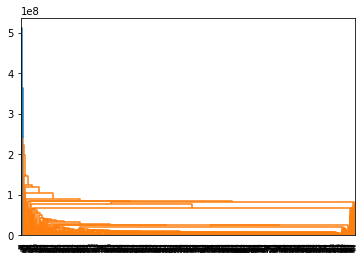

In [11]:
distance_matrix=linkage(df_work)
dn=dendrogram(distance_matrix)

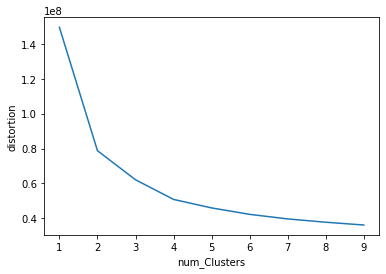

In [12]:
distortions=[]
num_clusters=range(1,10)

for i in num_clusters:
    cluster_center, distortion = kmeans(df_work, i)
    distortions.append(distortion)

df_for_kmeans=pd.DataFrame({'num_Clusters':num_clusters, 'distortion':distortions})

sns.lineplot(x='num_Clusters', y='distortion', data=df_for_kmeans)
plt.show()

In [18]:
cluster_center, _ = kmeans(df_work, 4)
df_work['cluster_label'], distortions_list = vq(df_work, cluster_center)

,quarter,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend,cluster_label
0,1,15.82,16.72,15.78,16.42,239655616,3.79267,0.000000,0.0,16.71,15.97,-4.428490,26,0.182704,2
1,1,16.71,16.71,15.64,15.97,242963398,-4.42849,1.380223,239655616.0,16.19,15.79,-2.470660,19,0.187852,3
2,1,16.19,16.38,15.60,15.79,138428495,-2.47066,-43.024959,242963398.0,15.87,16.13,1.638310,12,0.189994,2
3,1,15.87,16.63,15.82,16.13,151379173,1.63831,9.355500,138428495.0,16.18,17.14,5.933250,5,0.185989,2
4,1,16.18,17.39,16.18,17.14,154387761,5.93325,1.987452,151379173.0,17.33,17.37,0.230814,97,0.175029,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,2,80.22,82.63,80.07,82.63,68230855,3.00424,-21.355713,86758820.0,83.28,81.18,-2.521610,75,0.568801,1
746,2,83.28,83.75,80.18,81.18,78616295,-2.52161,15.221032,68230855.0,80.93,79.78,-1.420980,68,0.578960,1
747,2,80.93,81.87,79.72,79.78,92380844,-1.42098,17.508519,78616295.0,80.00,79.02,-1.225000,61,0.589120,2
748,2,80.00,80.82,78.33,79.02,100521400,-1.22500,8.811952,92380844.0,78.65,76.78,-2.377620,54,0.594786,2
